<a href="https://colab.research.google.com/github/esfandiaryfard/Calculator/blob/master/HomeWork1_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
import numpy as np
drive = drive.mount('/content/drive')
!unzip drive/MyDrive/Medical.zip -d Medical

Streaming output truncated to the last 5000 lines.
  inflating: Medical/HeadCT/005000.jpeg  
  inflating: Medical/HeadCT/005001.jpeg  
  inflating: Medical/HeadCT/005002.jpeg  
  inflating: Medical/HeadCT/005003.jpeg  
  inflating: Medical/HeadCT/005004.jpeg  
  inflating: Medical/HeadCT/005005.jpeg  
  inflating: Medical/HeadCT/005006.jpeg  
  inflating: Medical/HeadCT/005007.jpeg  
  inflating: Medical/HeadCT/005008.jpeg  
  inflating: Medical/HeadCT/005009.jpeg  
  inflating: Medical/HeadCT/005010.jpeg  
  inflating: Medical/HeadCT/005011.jpeg  
  inflating: Medical/HeadCT/005012.jpeg  
  inflating: Medical/HeadCT/005013.jpeg  
  inflating: Medical/HeadCT/005014.jpeg  
  inflating: Medical/HeadCT/005015.jpeg  
  inflating: Medical/HeadCT/005016.jpeg  
  inflating: Medical/HeadCT/005017.jpeg  
  inflating: Medical/HeadCT/005018.jpeg  
  inflating: Medical/HeadCT/005019.jpeg  
  inflating: Medical/HeadCT/005020.jpeg  
  inflating: Medical/HeadCT/005021.jpeg  
  inflating: Medical/Head

In [3]:
dataset = torchvision.datasets.ImageFolder('Medical/')
num_train = len(dataset)
train_idx = list(range(num_train))

test_frac =0.1

num_test = int(num_train * test_frac) 
num_train = num_train - num_test

test_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]


print(f"{num_train} samples used as train set")
print(f"{num_test}  samples used as test set")

53059 samples used as train set
5895  samples used as test set


In [4]:
import random

random.shuffle(train_idx)
for i in range(10):
  print(train_idx[i])

14016
31303
28603
32391
11559
29996
21568
25577
26344
3982


In [5]:
val_frac =0.1

num_val = int(num_train * val_frac) 
num_train = num_train - num_val

val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]


print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as test set")

47754 samples used as train set
5305  samples used as test set


In [6]:
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
  transforms.RandomRotation(degrees=(0, 20)),
  transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder('Medical/', transform=data_transform)

test_set = Subset(dataset, test_idx)
val_set = Subset(dataset, val_idx)
train_set = Subset(dataset, train_idx)

train_loader = DataLoader(
    train_set, batch_size=64, num_workers=0, shuffle=True
    )
val_loader   = DataLoader(
    val_set,   batch_size=64, num_workers=0, shuffle=False
    )
test_loader  = DataLoader(
    test_set,  batch_size=64, num_workers=0, shuffle=False
    )

In [7]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
  def forward(self, x):
    x = self.conv_layer(x)
    return x
  
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [8]:
test_x, _ = train_set[0] 
test_x.size()

torch.Size([3, 64, 64])

In [9]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 64, 64])

In [10]:
output = model(test_x)
output.shape

torch.Size([1, 256, 13, 13])

In [11]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

43264


In [12]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    
    self.fc_layers = nn.Sequential(
        nn.Linear(43264, 1024),
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(1024, 10)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # x has size: [B,256,4,4]; before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) # now x has size [B, 4096]
    output = self.fc_layers(x) # [B, 4096] --> [B, 1024] --> [B, 10]
    return output

In [13]:
# Create the model
model = CNN()
output = model(test_x)
output.shape

torch.Size([1, 10])

In [14]:
torch.cuda.is_available()

False

In [15]:
dev = torch.device('cuda')
print(dev)

cuda


In [16]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [17]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in tqdm(loaders[split],desc=split):
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [18]:
# Define dictionary of loaders
loaders = {"train": train_loader,   
           "val": val_loader,
           "test": test_loader}

UnboundLocalError: ignored

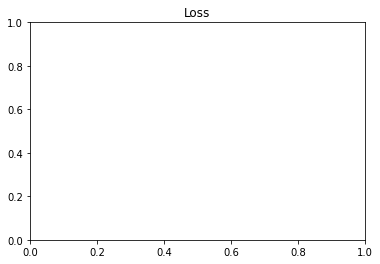

In [19]:
# Train model
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)

#RGB IMAGES
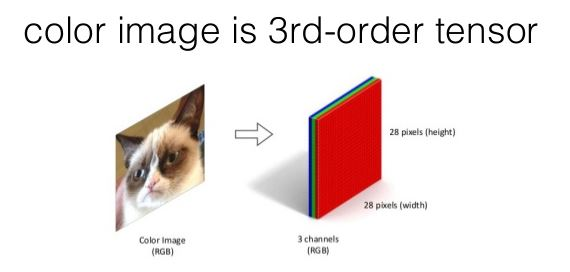

#CIFAR10
The CIFAR-10 dataset consists of 60000 32x32 RGB images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. 
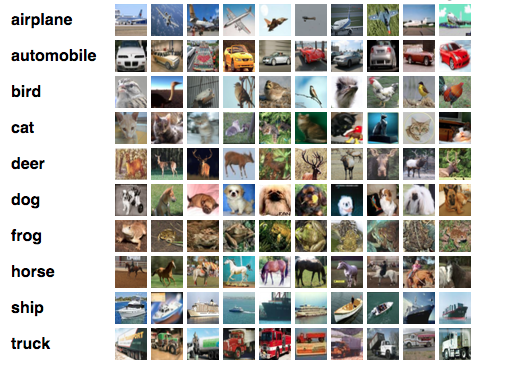

In [ ]:
!wget -c https://github.com/YoongiKim/CIFAR-10-images/archive/master.tar.gz
!tar -xzf master.tar.gz
!rm master.tar.gz
!rm ./CIFAR-10-images-master/README.md

--2022-04-08 14:37:49--  https://github.com/YoongiKim/CIFAR-10-images/archive/master.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/YoongiKim/CIFAR-10-images/tar.gz/refs/heads/master [following]
--2022-04-08 14:37:50--  https://codeload.github.com/YoongiKim/CIFAR-10-images/tar.gz/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘master.tar.gz’

master.tar.gz           [       <=>          ]  18.74M  14.0MB/s    in 1.3s    

2022-04-08 14:37:51 (14.0 MB/s) - ‘master.tar.gz’ saved [19652285]



In [ ]:
import os
dest_dir = "./CIFAR-10-images-master"
os.listdir(dest_dir)

['train', 'test']

In [ ]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image

In [ ]:
class MyCifar10Dataset(Dataset):
  def __init__(self, dset_dir, train=True, transforms=T.Compose([])):
    split = "train" if train else "test"
    self.dset_dir = Path(dset_dir)/split
    
    self.transforms = transforms

    self.files = []

    folders = sorted(os.listdir(self.dset_dir))
    for folder in folders:
      class_idx = folders.index(folder)

      folder_dir = self.dset_dir/folder

      files = os.listdir(folder_dir)

      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    item = self.files[i]
    file = item['file']
    class_idx = torch.tensor(item['class'])

    img = Image.open(file).convert("RGB")
    img = self.transforms(img)
    return img, class_idx

In [ ]:
transforms = T.Compose([
        T.Resize(32),
        T.ToTensor(),
        T.Normalize(0.5, 0.5)
    ])

In [ ]:
train_dset = MyCifar10Dataset(dest_dir, train=True, transforms=transforms)
test_dset = MyCifar10Dataset(dest_dir, train=False, transforms=transforms)

In [ ]:
data, label = train_dset[0]
print(data.shape)

torch.Size([3, 32, 32])


In [ ]:
train_loader = DataLoader(train_dset, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False, drop_last=False, num_workers=2)

In [ ]:
inputs, labels = next(iter(train_loader))
print(inputs.shape)
print(labels.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


# Classification on CIFAR-10

In [ ]:
import torch.nn as nn

class MyCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=10, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 5
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(in_channels=512, out_channels=out_size, kernel_size=2, padding=0, stride=1)
    )

  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.layers(x)
    print(output)
    return output.view(b, -1)

In [ ]:
net = MyCNN()
x = torch.rand(3, 3, 32, 32)
out = net(x)
print(out)
print(out.shape)

tensor([[[[ 0.0320]],

         [[-0.0177]],

         [[-0.0154]],

         [[ 0.0203]],

         [[ 0.0083]],

         [[-0.0131]],

         [[ 0.0057]],

         [[-0.0138]],

         [[ 0.0431]],

         [[ 0.0291]]],


        [[[ 0.0315]],

         [[-0.0169]],

         [[-0.0153]],

         [[ 0.0193]],

         [[ 0.0078]],

         [[-0.0146]],

         [[ 0.0062]],

         [[-0.0157]],

         [[ 0.0422]],

         [[ 0.0279]]],


        [[[ 0.0313]],

         [[-0.0171]],

         [[-0.0146]],

         [[ 0.0196]],

         [[ 0.0069]],

         [[-0.0144]],

         [[ 0.0062]],

         [[-0.0138]],

         [[ 0.0432]],

         [[ 0.0280]]]], grad_fn=<MkldnnConvolutionBackward0>)
tensor([[ 0.0320, -0.0177, -0.0154,  0.0203,  0.0083, -0.0131,  0.0057, -0.0138,
          0.0431,  0.0291],
        [ 0.0315, -0.0169, -0.0153,  0.0193,  0.0078, -0.0146,  0.0062, -0.0157,
          0.0422,  0.0279],
        [ 0.0313, -0.0171, -0.0146,  0.0196,  0.0

In [ ]:
import matplotlib.pyplot as plt

def train(net, loaders, optimizer, criterion, epochs=100, device=torch.device('cpu')):
    try:
        net = net.to(device)
        # Initialize history
        history_loss = {"train": [], "test": []}
        history_accuracy = {"train": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            print(f"Running epoch: {epoch}")
            # Initialize epoch variables
            sum_loss = {"train": 0, "test": 0}
            sum_accuracy = {"train": 0, "test": 0}
            # Process each split
            for split in ["train", "test"]:
                if split == "test":
                    net.eval()
                else:
                    net.train()
                # Process each batch
                for (input, labels) in tqdm(loaders[split],desc=split):
                    # Move to CUDA
                    input = input.to(device)
                    labels = labels.to(device)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "test"]}
            # Update history
            for split in ["train", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

Running epoch: 0


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: TrL=2.2468, TrA=0.1742, TeL=2.0451, TeA=0.2577,
Running epoch: 1


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: TrL=1.9052, TrA=0.3073, TeL=1.7384, TeA=0.3727,
Running epoch: 2


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: TrL=1.6377, TrA=0.4061, TeL=1.5279, TeA=0.4372,
Running epoch: 3


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: TrL=1.4959, TrA=0.4624, TeL=1.4543, TeA=0.4661,
Running epoch: 4


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: TrL=1.3945, TrA=0.5008, TeL=1.3499, TeA=0.5120,
Running epoch: 5


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: TrL=1.3051, TrA=0.5350, TeL=1.2777, TeA=0.5404,
Running epoch: 6


train:   0%|          | 0/1562 [00:00<?, ?it/s]

test:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: TrL=1.2112, TrA=0.5713, TeL=1.1852, TeA=0.5818,
Running epoch: 7


train:   0%|          | 0/1562 [00:00<?, ?it/s]

Interrupted


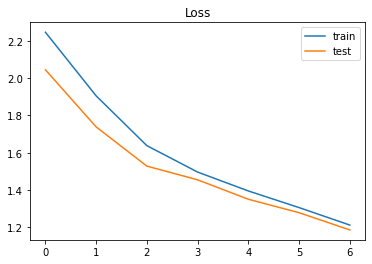

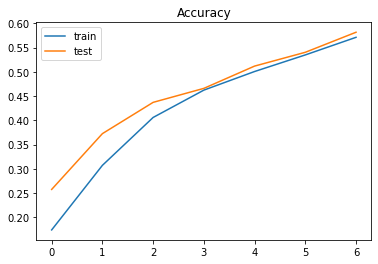

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net = MyCNN()
optimizer = optim.SGD(net.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()

train_dset = MyCifar10Dataset(dest_dir, train=True, transforms=transforms)
test_dset = MyCifar10Dataset(dest_dir, train=False, transforms=transforms)

train_loader = DataLoader(train_dset, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False, drop_last=False, num_workers=2)

# Define dictionary of loaders
loaders = {"train": train_loader,
           "test": test_loader}

train(net, loaders, optimizer, criterion, epochs=100, device=device)